# <center> ___Group Project Notebook___</center>

# Imports

In [48]:
import pandas as pd
import numpy as np

from scipy.optimize import newton, fsolve, bisect

import secrets

import matplotlib.pyplot as plt

import os

from IPython import get_ipython
from IPython.display import Image, display


from comp_econ import comp_econ as ce

# Problem 1: Expected value and variance of the international price of bananas.

## To find the equilibrium price p_star, we need a function P in terms of thetas and alphas.<br> p_star = p(theta_s, theta_us, theta_rw, alpha_s, alpha_us, alpha_rw).<br>Use the given equations and fsolve for P.

In [49]:
def p(
    _log_price: float, 
    _theta_s: float,
    _theta_us: float,
    _theta_rw: float,
    _alpha_s: float,
    _alpha_us: float,
    _alpha_rw: float
    ) -> float:
    """
    S = D_us + D_rw\n
    D_us + D_rw - S = 0\n
    (theta_us * (P ** -alpha_us)) + (theta_rw * (P ** -alpha_rw)) - (theta_s * (P ** alpha_s))\n
    """
        
    # Account for the possibility that fsolve will consider negative prices as a solution.
    _price = np.exp(_log_price)

    return (_theta_us * (_price ** -_alpha_us)) + (_theta_rw * (_price ** -_alpha_rw)) - (_theta_s * (_price ** _alpha_s))
    


## Define thetas and alphas.

In [50]:
# Generator instance, per the numpy docs.
# https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
# Set a seed for reproducable results.
# rng = np.random.default_rng(seed=123)
rng = np.random.default_rng()
# Number of samples to draw.
N = 10_000

# theta_s ~ lnN(0, 0.7)
theta_s = rng.lognormal(mean=0, sigma=(0.7**(1/2)), size=N)

# theta_us ~ lnN(0, 0.01)
theta_us = rng.lognormal(mean=0, sigma=(0.01**(1/2)), size=N)

# theta_rw ~ lnN(0, 0.03)
theta_rw = rng.lognormal(mean=0, sigma=(0.03**(1/2)), size=N)

alpha_s = 0.7
alpha_us = 0.3
alpha_rw = 0.2


## Use fsolve to find the equilibrium price p_star.

In [51]:
# Create Nx1 numpy arrays having nan values.
log_p_star = np.full(N, np.nan)
p_star = np.full(N, np.nan)

# Loop over every simulated p_i = p(theta_s[i], ..., alpha_rw).
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
for i in range(N):
    log_p_i = fsolve(
        p,
        x0=0,
        args=(theta_s[i], theta_us[i], theta_rw[i], alpha_s, alpha_us, alpha_rw)
    )[0]
    # Undo the log transform of price.
    p_i_star = np.exp(log_p_i)
    
    # Update the arrays.
    log_p_star[i] = log_p_i
    p_star[i] = p_i_star


## Confirm that each p_i_star solves its corresponding ith equation `p(log_p_star[i], theta_s[i], theta_us[i], theta_rw[i], alpha_s, alpha_us, alpha_rw)`.


In [52]:
for i in range(N):
  assert np.isclose(
    p(log_p_star[i],
      theta_s[i],
      theta_us[i],
      theta_rw[i],
      alpha_s,
      alpha_us,
      alpha_rw
    ),
    0
  ), f"p_star does not solve the equation in function p(_price, ..., _alpha_rw) at index {i}"


## Expectation and variance of p_star.

In [57]:
expected_p_star = p_star.mean()
print(f"Expected equilibrium price, E[p_star] = {expected_p_star}")

var_p_star = p_star.var(ddof=1)
print(f"Variance of equilibrium price, Var[p_star] = {var_p_star}")

Expected equilibrium price, E[p_star] = 3.060474589897695
Variance of equilibrium price, Var[p_star] = 11.400913742980565


## Plot of p_star and fitted Lognormal PDF.

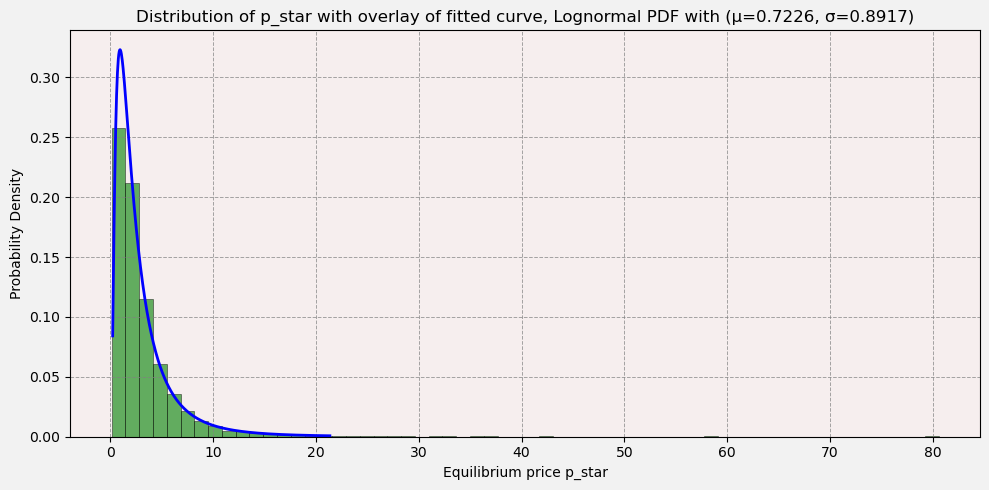

In [54]:
# Fitted lognormal parameters.
# Pull the fitted values from log_p_star, not p_star, because want to overlay with a fitted Lognormal PDF.
mu_fit = log_p_star.mean()
sigma_fit = log_p_star.std(ddof=1)

# x-grid for the fitted Lognormal PDF.
x = np.linspace(np.percentile(p_star, 0.5), np.percentile(p_star, 99.5), 500)

# Formula of a Lognormal PDF.
pdf_fit = (1 / (x * sigma_fit * np.sqrt(2*np.pi))) * \
          np.exp(-(np.log(x) - mu_fit)**2 / (2 * sigma_fit**2))

# Assign fig and ax with background.
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("#f2f2f2")
ax.set_facecolor("#F7EEEEFA")

# Create the grid.
ax.grid(
    True,
    linestyle="--",
    linewidth=0.7,
    alpha=0.7,
    color="gray"
)

# Histogram plot with edges.
ax.hist(
    p_star,
    bins=60,
    density=True,
    alpha=0.6,
    color="green",
    edgecolor="black",
    linewidth=0.5
)

# Plot the Lognormal PDF.
ax.plot(x, pdf_fit, linewidth=2, color="blue")

ax.set_xlabel("Equilibrium price p_star")
ax.set_ylabel("Probability Density")
ax.set_title(f"Distribution of p_star with overlay of fitted curve, Lognormal PDF with (μ={np.round(mu_fit, 4)}, σ={np.round(sigma_fit, 4)})")

plt.tight_layout()
plt.show()
